In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'datasets/lung/train'
valid_path = 'datasets/lung/test'

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

    # useful for getting number of classes
folders = glob('datasets/lung/train/*')

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [3]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

training_set = train_datagen.flow_from_directory('datasets/lung/train',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory('datasets/lung/test',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
# fit the model
r = model.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=5,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

Epoch 1/5
163/163 [==============================] - 1641s 10s/step - loss: 0.1786 - acc: 0.9314 - val_loss: 0.3726 - val_acc: 0.9199
Epoch 2/5
163/163 [==============================] - 1608s 10s/step - loss: 0.1105 - acc: 0.9586 - val_loss: 0.1298 - val_acc: 0.9151
Epoch 3/5
163/163 [==============================] - 1661s 10s/step - loss: 0.0889 - acc: 0.9663 - val_loss: 0.2708 - val_acc: 0.9071
Epoch 4/5
163/163 [==============================] - 1597s 10s/step - loss: 0.1112 - acc: 0.9576 - val_loss: 0.0631 - val_acc: 0.9295
Epoch 5/5
163/163 [==============================] - 1661s 10s/step - loss: 0.0805 - acc: 0.9720 - val_loss: 0.3650 - val_acc: 0.9087


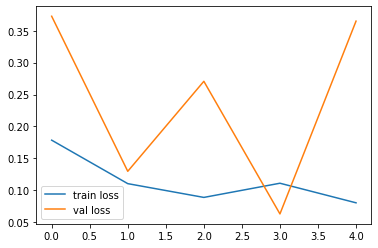

<Figure size 432x288 with 0 Axes>

In [6]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

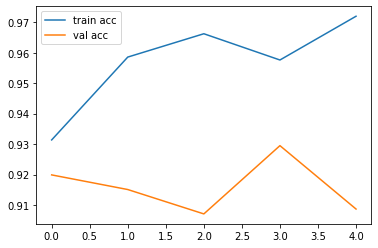

<Figure size 432x288 with 0 Axes>

In [7]:
# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [8]:
import tensorflow as tf

from keras.models import load_model

model.save('model_vgg19.h5')